## Experiment design

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import random
np.random.seed(10)
import scipy

In [2]:
treat_data = pd.read_csv("treatment_features.csv",header=None)
action_data = pd.read_csv("treatment_actions.csv",header=None)
outcome_data = pd.read_csv("treatment_outcomes.csv",header=None)

symptoms_names = ['Covid-Recovered', 'Covid-Positive', 'No-Taste/Smell', 'Fever', 'Headache', 
                  'Pneumonia', 'Stomach', 'Myocarditis', 'Blood-Clots', 'Death','Age', 'Gender', 'Income']
cols = ( symptoms_names +
         [f'Gene_{i+1:03}' for i in range(128)] +
         ['Asthma', 'Obesity', 'Smoking', 'Diabetes', 'Heart disease', 'Hypertension',
         'Vacc_1', 'Vacc_2', 'Vacc_3'])

treat_data.columns = cols
outcome_data.columns = cols[:10]
action_data.columns = ['Treatment_1', 'Treatment_2']

## Estimaring the $P(y|x,a)$:

In [3]:
X = treat_data
Y = outcome_data
a = action_data 

In [4]:
X1 = pd.DataFrame([X.iloc[i] for i in range(len(a)) if a.iloc[i][0] == 1])
X2 = pd.DataFrame([X.iloc[i] for i in range(len(a)) if a.iloc[i][1] == 1])

y1 = pd.DataFrame([Y.iloc[i] for i in range(len(a)) if a.iloc[i][0] == 1])
y2 = pd.DataFrame([Y.iloc[i] for i in range(len(a)) if a.iloc[i][1] == 1])

In [5]:
def train_pred(X,y):
    X_tr,X_ts,Y_tr,Y_ts = train_test_split(X,y,test_size=0.33,random_state=1)
    
    scaler = StandardScaler().fit(X_tr)
    X_tr = scaler.transform(X_tr)
    scaler.fit(X_ts)
    X_ts = scaler.transform(X_ts)

    #training
    mlp = MLPClassifier(activation='logistic', max_iter=10_000)
    mlp.fit(X_tr,Y_tr)

    #predicitng
    
    return np.mean(mlp.predict_proba(X_ts),axis=0)

## Utility

In [ ]:
"""def get_utility(features, action, outcome):
    rewards = np.zeros(10)
    weights = np.zeros(10)
    np.random.seed(10)
    action_cost = np.random.uniform(0,1, size = action.shape[0])
    
    if len(action_cost) ==3:
        action_cost[2] = 0;
    
if len(action.shape)==1:
        action_cost = np.random.uniform(0,1)
    else:
        action_cost = np.zeros(action.shape[1])
        for i in range(len(action_cost)):
            action_cost[i] = np.random.uniform(0,1)"

    if 0 < features['Age'] <= 30: #young
        weights = np.array([0,0,0.1,0.1,0.1,0.5,0.2,0.5,1.0,100])
    elif 30 < features['Age'] <= 60: #middel age
        weights = np.array([0,0,0.2,0.2,0.2,0.7,0.4,0.7,2.0,90])
    else: #old
        weights = np.array([0,0,0.5,0.5,0.5,1.2,0.5,1.0,10.0,70])
    rewards -= weights * outcome
    
    cost = 0
    for j in range(action.shape[0]):
        if action.iloc[j] == 1:
            cost = action_cost[j]

        
    utility = np.sum(rewards) - cost
    
    return utility,rewards-cost

In [6]:
def get_utility(features, action, outcome):
    np.random.seed(10)
    rewards = np.zeros(10)
    weights = np.zeros(10)
    
    if len(features.shape) == len(action.shape) == len(outcome.shape) == 1:
        if 0 < features['Age'] <= 30: #young
            weights = 10*np.array([0,0,0.1,0.1,0.1,0.5,0.2,0.5,1.0,100])
        elif 30 < features['Age'] <= 60: #middel age
            weights = 10*np.array([0,0,0.2,0.2,0.2,0.7,0.4,0.7,2.0,90])
        else: #old
            weights = 10*np.array([0,0,0.5,0.5,0.5,1.2,0.5,1.0,10.0,70])

        rewards -= weights*outcome + np.random.uniform()
        return rewards

    np.random.seed(10)
    action_cost = np.random.uniform(0.5,1.5, size = action.shape[1])
    
    for i in range(features.shape[0]):
        if features['Age'].min() < features['Age'].iloc[i] <= 30: #young
            weights = 10*np.array([0,0,0.1,0.1,0.1,0.5,0.2,0.5,1.0,100])
        elif 30 < features['Age'].iloc[i] <= 60: #middel age
            weights = 10*np.array([0,0,0.2,0.2,0.2,0.7,0.4,0.7,2.0,90])
        else: #old
            weights = 10*np.array([0,0,0.5,0.5,0.5,1.2,0.5,1.0,4.0,70])
        
        cost = 0
        for j in range(action.shape[1]):
            if action.iloc[i,j] == 1:
                cost += action_cost[j]

        rewards -= weights*outcome.iloc[i] + cost
    
    return rewards

The sensitivity of the utility based on the age categories.

## The exponential mechanism

In [ ]:
def exponential_mechanism(features,actions,outcome,epsilon,sensitivity,p_proba):
    """
    Given a set of actions and a utility function, this function returns the noisy 'best' action.
    Since our utility function at the moment does not depend on actions, only outcome, the results are expected to be random.  
    """
    best_actions = []
    predicted_outcome = np.zeros(10)
    for i in range(features.shape[0]):
        utility = np.zeros(actions.shape[1])
        for j,action in enumerate(actions):
            if action == 'No_Action':
                predicted_outcome = features.iloc[i,:10]
            else:
                for k in range(10):
                    predicted_outcome[k] = np.random.choice(2,p=[1-p_proba[j][k],p_proba[j][k]])

            utility[j] = get_utility(features.iloc[i], actions.iloc[j], predicted_outcome)[0] 

        policy_probs = np.exp(epsilon*utility/2*sensitivity)
        #print(policy_probs)
        policy_probs = policy_probs/np.linalg.norm(policy_probs, ord=1)
        #print(policy_probs)

        best_actions.append(np.random.choice(actions.columns, 1, p=policy_probs.ravel())[0])
    return best_actions

In [ ]:
p_proba = [y1_proba,y2_proba,np.mean([y1_proba,y2_proba],axis = 0)]

def tune_epsilon(epsilon):
    EM_1 = exponential_mechanism(treat_data,pd.DataFrame({'Action1':[1,0,0],'Action2':[0,1,0],'No_Action':[0,0,1]}),outcome_data,epsilon,1/10,p_proba)

    s1 = 0
    s2 = 0
    s3 = 0
    for e in EM_1:
        if e == 'Action1':
            s1 +=1
        elif e == 'Action2':
            s2 +=1
        else:
            s3 += 1
    print(epsilon)
    print(f'action1: {s1}')
    print(f'action2: {s2}')
    print(f'no_action: {s3}')
    print()
    
tune_epsilon(0.1)
tune_epsilon(0.5)
tune_epsilon(1)
tune_epsilon(10)

## Estimating:
$$\sum P(y|x,a) \; u(a,y)$$

In [7]:
def compute_utility(X,action_data,y):
    u = 0
    for i in range (X.shape[0]):
        u += get_utility(X.iloc[i],action_data.iloc[i],y.iloc[i])[1]
        
    return u

In [68]:
u1 = get_utility(X1,a1,y1)
u2 = get_utility(X2,a2,y2)

In [69]:
y2_proba = train_pred(X2,y2)
y1_proba = train_pred(X1,y1)

In [70]:
expected_utility1_vec = np.array([u*y for u,y in zip(u1,y1_proba)])
expected_utility2_vec = np.array([u*y for u,y in zip(u2,y2_proba)])

In [71]:
expected_utility1 = y1_proba.T @ u1 / X1.shape[0]
expected_utility1

-1.5033997300266524

In [72]:
expected_utility2 = y2_proba.T @ u2 / X2.shape[0]
expected_utility2

-2.090214101087607

### Defining the utility

In [13]:
#finding optimal action for given symptoms for each individual. Optimal policy

def get_action():
    optimal_action = np.zeros([X.shape[0],2])
    for i in range(X.shape[0]):
        index = np.argwhere(np.array(X.iloc[i,2:10]) == np.ones(8)).flatten().tolist()

        if len(index) > 0:
            if np.sum(expected_utility1_vec[index]) >= np.sum(expected_utility2_vec[index]):
                optimal_action[i,0] = 1
            else:
                optimal_action[i,1] = 1
                
    return optimal_action

## Bootstrap the data for:
Provide error bounds on the expected utility and explain how those were obtained.

## Expected utility for improved policy

In [14]:
optimal_action = get_action()

In [15]:
X1_improved = pd.DataFrame([X.iloc[i] for i in range(len(optimal_action)) if optimal_action[i][0] == 1])
X2_improved = pd.DataFrame([X.iloc[i] for i in range(len(optimal_action)) if optimal_action[i][1] == 1])

In [16]:
#taken from "simulator.py" file

def treatment(X,p):
    A = np.random.uniform(size=[2,10])
    treatments = np.zeros([X.shape[0], 2])
    result = np.zeros([X.shape[0], 10])
    for t in range(X.shape[0]):
        treatments[t] = optimal_action[t]
        r = np.array(np.matrix(treatments[t]) * A).flatten()
        for k in range(10):
            result[t,k] = np.random.choice(2,p=[1-p[k],p[k]])
        ##print("X:", X[t,:self.n_symptoms] , "Y:",  result[t])
    return treatments, result

In [17]:
p_symptoms1 = np.zeros(8)
p_symptoms2 = np.zeros(8)
for i in range(8):
    p_symptoms1[i] = y1.iloc[:,i+2].mean()
    p_symptoms2[i] = y2.iloc[:,i+2].mean()

In [18]:
Y1_new = pd.DataFrame(treatment(X1_improved.iloc[:,0:10],y1_proba)[1], columns = symptoms_names[:10])
Y2_new = pd.DataFrame(treatment(X2_improved.iloc[:,0:10],y2_proba)[1], columns = symptoms_names[:10])

In [19]:
new_action = pd.DataFrame({'Treatment1':optimal_action[:,0],'Treatment2':optimal_action[:,1]})

In [74]:
new_actions = pd.DataFrame(optimal_action)
#dividing the optimal action
new_a1 = new_actions[new_actions.iloc[:,0] == 1]
new_a2 = new_actions[new_actions.iloc[:,1] == 1]

#doing the same as above for computing the expected utility
u1_new = get_utility(X1_improved,new_a1,Y1_new)
u2_new = get_utility(X2_improved,new_a2,Y2_new)

In [75]:
y2_new_proba = train_pred(X2_improved.iloc[:,2:10],Y2_new)
y1_new_proba = train_pred(X1_improved.iloc[:,2:10],Y1_new)

In [76]:
y1_new_proba

array([1.04298909e-01, 9.99686346e-01, 3.85669709e-02, 5.42047727e-03,
       3.48188992e-04, 4.29136524e-03, 1.16493148e-03, 1.65897963e-02,
       2.15166998e-03, 1.13826100e-03])

In [77]:
new_expected_utility1 = y1_new_proba.T @ u1_new
new_expected_utility2 = y2_new_proba.T @ u2_new

In [82]:
new_expected_utility1/X1_improved.shape[0]

-1.4982385733781118

In [83]:
new_expected_utility2/X2_improved.shape[0]

-1.6635119412220094

In [80]:
new_expected_utility1

-4216.043345486007

In [81]:
new_expected_utility2

-763.5519810209023

## Plotting the new data vs old data

In [28]:
def make_hist(X,X_improved,action_nr):
    plt.hist(X['Age'],bins=50,color = "skyblue",label='Historical data',alpha=0.7)
    plt.hist(X_improved['Age'],bins=50,label='Improved policy',alpha=0.7)
    plt.ylabel('Frequencies')
    plt.xlabel('Age')
    plt.title(f'Distribution for Action {action_nr}')
    plt.legend()
    plt.savefig(f'/Users/roaka001/Documents/OneDrive/IN-STK5000/fairness_and_privacy/figs_policy/action_{action_nr}')

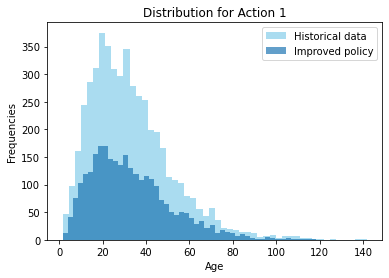

In [29]:
make_hist(X1,X1_improved,1)

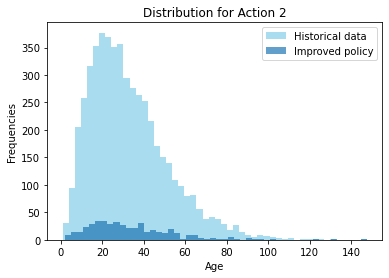

In [30]:
make_hist(X2,X2_improved,2)

# Error bounds: confidens intervall

In [60]:
def confidence_interval(features, actions, outcome):
    n = features.shape[0]

    u = get_utility(features, actions, outcome)
    eu =  u.T @ train_pred(features,outcome)/n
    m = np.sum(u)/(outcome.shape[1]*n)
    
    s2 = 0
    for i in range(n):
        s2 += (np.sum(get_utility(features.iloc[i], actions.iloc[i], outcome.iloc[i]))/outcome.shape[1] - m)**2
    s2 = s2/(n-1)
    s = np.sqrt(s2)

    t = scipy.stats.t(n-1)
    percentile95 = t.interval(0.975)[0]
    ci = (eu - percentile95*(s/np.sqrt(n)), eu + percentile95*(s/np.sqrt(n)))

    return ci

In [61]:
a1 = action_data[action_data.iloc[:,0] == 1]
a2 = action_data[action_data.iloc[:,1] == 1]

In [62]:
confidence_interval(X1,a1,y1)

(-1.2790708252994114, -1.7272383432280067)

In [63]:
confidence_interval(X2,a2,y2)

(-1.5390055863581198, -2.6414226158170946)

In [86]:
confidence_interval(X1_improved,new_a1,Y1_new)

(-1.2425517737387357, -1.5219074725668047)

In [84]:
confidence_interval(X2_improved,new_a2,Y2_new)

(0.4553587127584242, -2.9555947121045985)